# **Training object detection model using mmdetection on kaggle**

## _Clonning the mmdetection git repository_

In [124]:
!git clone https://github.com/open-mmlab/mmdetection.git

Cloning into 'mmdetection'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 9445 (delta 1), reused 0 (delta 0), pack-reused 9424
Receiving objects: 100% (9445/9445), 6.37 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (6576/6576), done.


## _Change the directory to mmdetection_

In [ ]:
%cd mmdetection

In [ ]:
!ls

## _Installing the required packages_

In [125]:
!pip install -r requirements/build.txt

## _Installation of all the packages_

In [ ]:
!pip install -v -e .

## _Upload the data to kaggle and verify by running the below code._

In [126]:
!ls /kaggle/input/datafire/data/VOC2007/

Annotations  ImageSets	JPEGImages


## _Change directory to mmdetection/config_

In [127]:
%cd /kaggle/working/mmdetection/configs/

/kaggle/working/mmdetection/configs


## _Modify the required config file for the respective detector you want to use in your project, here i have used ssd300._

In [128]:
%%writefile ssd300_vocdata.py
# %load ssd300_vocdata.py
# model settings
input_size = 300
model = dict(
    type='SingleStageDetector',
    pretrained='open-mmlab://vgg16_caffe',
    backbone=dict(
        type='SSDVGG',
        input_size=input_size,
        depth=16,
        with_last_pool=False,
        ceil_mode=True,
        out_indices=(3, 4),
        out_feature_indices=(22, 34),
        l2_norm_scale=20),
    neck=None,
    bbox_head=dict(
        type='SSDHead',
        input_size=input_size,
        in_channels=(512, 1024, 512, 256, 256, 256),
        num_classes=2,
        anchor_strides=(8, 16, 32, 64, 100, 300),
        basesize_ratio_range=(0.2, 0.9),
        anchor_ratios=([2], [2, 3], [2, 3], [2, 3], [2], [2]),
        target_means=(.0, .0, .0, .0),
        target_stds=(0.1, 0.1, 0.2, 0.2)))
# model training and testing settings
cudnn_benchmark = True
train_cfg = dict(
    assigner=dict(
        type='MaxIoUAssigner',
        pos_iou_thr=0.5,
        neg_iou_thr=0.5,
        min_pos_iou=0.,
        ignore_iof_thr=-1,
        gt_max_assign_all=False),
    smoothl1_beta=1.,
    allowed_border=-1,
    pos_weight=-1,
    neg_pos_ratio=3,
    debug=False)
test_cfg = dict(
    nms=dict(type='nms', iou_thr=0.45),
    min_bbox_size=0,
    score_thr=0.02,
    max_per_img=200)
# dataset settings
dataset_type = 'VOCDataset'
data_root = '/kaggle/input/datafire/data/VOC2007/'
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[1, 1, 1], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile', to_float32=True),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(
        type='PhotoMetricDistortion',
        brightness_delta=32,
        contrast_range=(0.5, 1.5),
        saturation_range=(0.5, 1.5),
        hue_delta=18),
    dict(
        type='Expand',
        mean=img_norm_cfg['mean'],
        to_rgb=img_norm_cfg['to_rgb'],
        ratio_range=(1, 4)),
    dict(
        type='MinIoURandomCrop',
        min_ious=(0.1, 0.3, 0.5, 0.7, 0.9),
        min_crop_size=0.3),
    dict(type='Resize', img_scale=(300, 300), keep_ratio=False),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(300, 300),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=False),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    imgs_per_gpu=8,
    workers_per_gpu=3,
    train=dict(
        type='RepeatDataset',
        times=10,
        dataset=dict(
            type=dataset_type,
            ann_file=[
                data_root + 'ImageSets/Main/trainval.txt',
                data_root + 'ImageSets/Main/trainval.txt'
            ],
            img_prefix=[data_root, data_root],
            pipeline=train_pipeline)),
    val=dict(
        type=dataset_type,
        ann_file=data_root + 'ImageSets/Main/test.txt',
        img_prefix=data_root,
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
        ann_file=data_root + 'ImageSets/Main/test.txt',
        img_prefix=data_root,
        pipeline=test_pipeline))
evaluation = dict(interval=1, metric='mAP')
# optimizer
optimizer = dict(type='SGD', lr=1e-3, momentum=0.9, weight_decay=5e-4)
optimizer_config = dict()
# learning policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=500,
    warmup_ratio=1.0 / 3,
    step=[16, 20])
checkpoint_config = dict(interval=1)
# yapf:disable
log_config = dict(
    interval=50,
    hooks=[
        dict(type='TextLoggerHook'),
        # dict(type='TensorboardLoggerHook')
    ])
# yapf:enable
# runtime settings
total_epochs = 24
dist_params = dict(backend='nccl')
log_level = 'INFO'
work_dir = '/kaggle/working/mmdetection/docker/'
load_from = None
resume_from = None
workflow = [('train', 1)]


Overwriting ssd300_vocdata.py


## _Verify the config file by running ls command._

In [ ]:
!ls

## _Change the working directory to mmdetection/mmdet/datasets/_

In [129]:
%cd /kaggle/working/mmdetection/mmdet/datasets/

/kaggle/working/mmdetection/mmdet/datasets


## _Modify the voc.py file._

In [130]:
%%writefile voc.py
# %load voc.py
from mmdet.core import eval_map, eval_recalls
from .registry import DATASETS
from .xml_style import XMLDataset


@DATASETS.register_module
class VOCDataset(XMLDataset):

    CLASSES = ('fire_extinguisher',)

    def __init__(self, **kwargs):
        super(VOCDataset, self).__init__(**kwargs)
        if 'VOC2007' in self.img_prefix:
            self.year = 2007
        elif 'VOC2012' in self.img_prefix:
            self.year = 2012
        else:
            raise ValueError('Cannot infer dataset year from img_prefix')

    def evaluate(self,
                 results,
                 metric='mAP',
                 logger=None,
                 proposal_nums=(100, 300, 1000),
                 iou_thr=0.5,
                 scale_ranges=None):
        if not isinstance(metric, str):
            assert len(metric) == 1
            metric = metric[0]
        allowed_metrics = ['mAP', 'recall']
        if metric not in allowed_metrics:
            raise KeyError('metric {} is not supported'.format(metric))
        annotations = [self.get_ann_info(i) for i in range(len(self))]
        eval_results = {}
        if metric == 'mAP':
            assert isinstance(iou_thr, float)
            if self.year == 2007:
                ds_name = 'voc07'
            else:
                ds_name = self.dataset.CLASSES
            mean_ap, _ = eval_map(
                results,
                annotations,
                scale_ranges=None,
                iou_thr=iou_thr,
                dataset=ds_name,
                logger=logger)
            eval_results['mAP'] = mean_ap
        elif metric == 'recall':
            gt_bboxes = [ann['bboxes'] for ann in annotations]
            if isinstance(iou_thr, float):
                iou_thr = [iou_thr]
            recalls = eval_recalls(
                gt_bboxes, results, proposal_nums, iou_thr, logger=logger)
            for i, num in enumerate(proposal_nums):
                for j, iou in enumerate(iou_thr):
                    eval_results['recall@{}@{}'.format(num, iou)] = recalls[i,
                                                                            j]
            if recalls.shape[1] > 1:
                ar = recalls.mean(axis=1)
                for i, num in enumerate(proposal_nums):
                    eval_results['AR@{}'.format(num)] = ar[i]
        return eval_results


Overwriting voc.py


## _Change the working directory to mmdetection_

In [131]:
%cd /kaggle/working/mmdetection/

/kaggle/working/mmdetection


## _Run setup.py to install and save the changes made in voc.py as well as config file._

In [ ]:
!python setup.py install

## _Change the working directory to tools_

In [ ]:
%cd tools

## _Install pycocotools_

In [ ]:
!pip install pycocotools

## _Train the model by giving the path of your config file._

In [ ]:
!python train.py /kaggle/working/mmdetection/configs/ssd300_vocdata.py

## _Change directory to mmdetection_

In [138]:
%cd /kaggle/working/mmdetection/

/kaggle/working/mmdetection


## _Test your model by giving the config file path, checkpoint path and path of the new image file, the result of single file is saved as result.jpg_

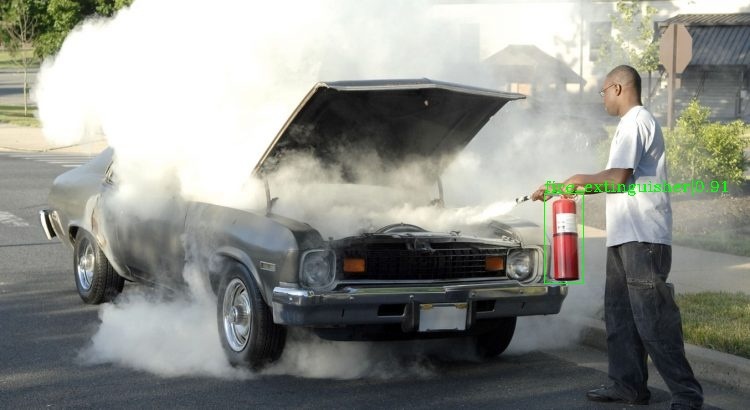

In [141]:
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result, init_detector

checkpoint_file = "/kaggle/working/mmdetection/docker/latest.pth"
config_fname = "/kaggle/working/mmdetection/configs/ssd300_vocdata.py"
score_thr = 0.55

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = '/kaggle/input/dataset1/Car-Fire-Extinguisher.jpg'
result = inference_detector(model, img)
show_result(img, result, model.CLASSES, score_thr=score_thr, out_file="result.jpg")

# Show the image with bbox overlays.
from IPython.display import Image
Image(filename='result.jpg')

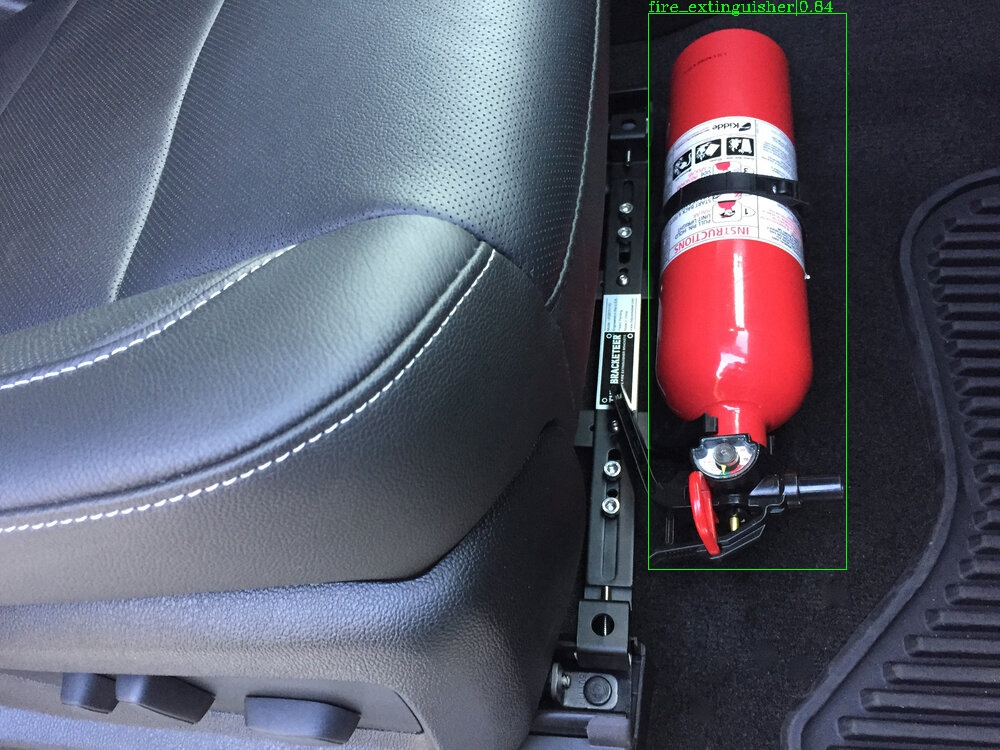

In [142]:
from mmcv.runner import load_checkpoint
from mmdet.apis import inference_detector, show_result, init_detector

checkpoint_file = "/kaggle/working/mmdetection/docker/latest.pth"
config_fname = "/kaggle/working/mmdetection/configs/ssd300_vocdata.py"
score_thr = 0.55

# build the model from a config file and a checkpoint file
model = init_detector(config_fname, checkpoint_file)

# test a single image and show the results
img = '/kaggle/input/dataset/UFEB1317D-in-2017-Silverado-LTZ-Z71.jpg'
result = inference_detector(model, img)
show_result(img, result, model.CLASSES, score_thr=score_thr, out_file="result.jpg")

# Show the image with bbox overlays.
from IPython.display import Image
Image(filename='result.jpg')